In [1]:
import base.epsilon_rho as epsilon_rho
import numpy as np
from base import metrics
import tensorflow as tf
%load_ext autoreload
%autoreload 2

2025-02-26 14:27:13.847812: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-26 14:27:13.848371: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-26 14:27:13.851064: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-26 14:27:13.858984: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740547633.872559  341860 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740547633.87

In [2]:
from base import generator_gellmann
from base import generator_haar

n = 2
d = 2**n
gellmann_matrices = generator_gellmann.generate_gellmann_matrices(d)

# Generate 6^n density matrices
rho_list = generator_haar.generate_n_qubits_rho_haar(n)

print(f"Generated {len(rho_list)} of {rho_list[0].shape} rho.")
# ----------------------------
single_qubits_projectors = generator_gellmann.generate_measurement_projector_gellmann(num_qubits = 1)
measurement_operators = generator_gellmann.generate_measurement_operators_gellmann(single_qubits_projectors, n)
print(f"Generated {len(measurement_operators)} of {measurement_operators[0].shape} M.")


Generated 36 of (4, 4) rho.
Generated 36 of (4, 4) M.


In [3]:
# ----------------------------
# Generate epsilon
epsilon = generator_haar.random_unitary(2**n)
print(f"Generated {epsilon.shape} epsilon.")
# Generate K list
unitary = generator_haar.haar(2**n)
kraus_operators = generator_haar.generate_kraus_operators(unitary)
print(f"Generated {len(kraus_operators)} of {kraus_operators[0].shape} kraus operators.")

Generated (4, 4) epsilon.
Generated 4 of (4, 4) kraus operators.


2025-02-26 14:27:20.459885: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [4]:
from base import fast_QPT_recreate
# ----------------------------
# Fast QPT based on multi-shot measurement
kraus_operators_res, cost_dict = fast_QPT_recreate.optimize_adam_kraus(measurement_operators, rho_list, epsilon, kraus_operators, n, 0.1, num_loop=200)
print(kraus_operators_res)
print(cost_dict)

tf.Tensor(0.7301347537917592, shape=(), dtype=float64)
tf.Tensor(0.5294771890652151, shape=(), dtype=float64)
tf.Tensor(0.3055826718215123, shape=(), dtype=float64)
tf.Tensor(0.1817832507002967, shape=(), dtype=float64)
tf.Tensor(0.10117871392291442, shape=(), dtype=float64)
tf.Tensor(0.05977939632224903, shape=(), dtype=float64)
tf.Tensor(0.04038767301473061, shape=(), dtype=float64)
tf.Tensor(0.03649454208445893, shape=(), dtype=float64)
tf.Tensor(0.037003500160039705, shape=(), dtype=float64)
tf.Tensor(0.03319008500528765, shape=(), dtype=float64)
tf.Tensor(0.03817976721434468, shape=(), dtype=float64)
tf.Tensor(0.02516325970349797, shape=(), dtype=float64)
tf.Tensor(0.02236776368559369, shape=(), dtype=float64)
tf.Tensor(0.01860306206967234, shape=(), dtype=float64)
tf.Tensor(0.01758558367313648, shape=(), dtype=float64)
tf.Tensor(0.0168306321006402, shape=(), dtype=float64)
tf.Tensor(0.015865251985909448, shape=(), dtype=float64)
tf.Tensor(0.01502966262038357, shape=(), dtype=floa

In [6]:
from base import optimize_algorithm
# ----------------------------
# Fast QPT based on single-shot measurement
kraus_operators_res_our_method, cost_dict_our_method = optimize_algorithm.optimize_adam_kraus_set(rho_list, epsilon, kraus_operators, n, alpha=0.1, num_loop=200)
print(kraus_operators_res_our_method)
print(cost_dict_our_method)

tf.Tensor(0.913839142467629, shape=(), dtype=float64)
tf.Tensor(0.6673750476055385, shape=(), dtype=float64)
tf.Tensor(0.36306473505319026, shape=(), dtype=float64)
tf.Tensor(0.18867288813046326, shape=(), dtype=float64)
tf.Tensor(0.11060273236505912, shape=(), dtype=float64)
tf.Tensor(0.07866095462405555, shape=(), dtype=float64)
tf.Tensor(0.06102038620307562, shape=(), dtype=float64)
tf.Tensor(0.03812587375190195, shape=(), dtype=float64)
tf.Tensor(0.025069172020340712, shape=(), dtype=float64)
tf.Tensor(0.01891399599167644, shape=(), dtype=float64)
tf.Tensor(0.01643156816333905, shape=(), dtype=float64)
tf.Tensor(0.014835509615018921, shape=(), dtype=float64)
tf.Tensor(0.012932432360870553, shape=(), dtype=float64)
tf.Tensor(0.011056858448028978, shape=(), dtype=float64)
tf.Tensor(0.010028280128305471, shape=(), dtype=float64)
tf.Tensor(0.010218662466696277, shape=(), dtype=float64)
tf.Tensor(0.011304749942180982, shape=(), dtype=float64)
tf.Tensor(0.012744012426510961, shape=(), dt

/tmp/ipykernel_341860/1592780722.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=14)


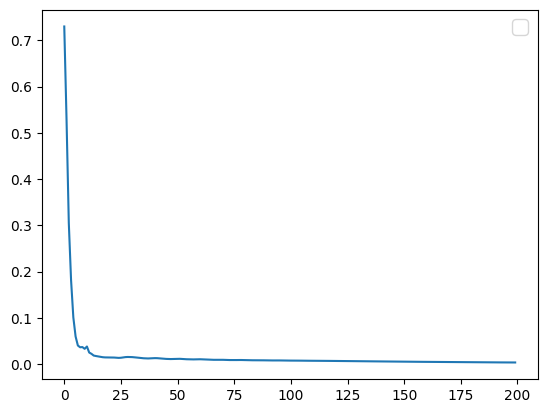

In [7]:
import matplotlib.pyplot as plt
plt.plot(cost_dict)
plt.legend(fontsize=14)
plt.show()

/tmp/ipykernel_341860/3578662721.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=14)


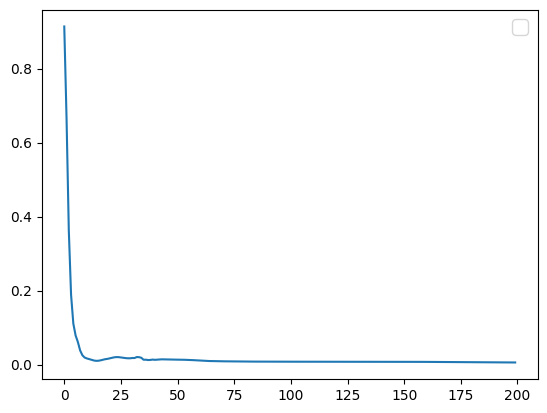

In [8]:
import matplotlib.pyplot as plt
plt.plot(cost_dict_our_method)
plt.legend(fontsize=14)
plt.show()

In [11]:
rho_test = generator_haar.generate_rho_haar(n)

rho2 = epsilon_rho.calculate_from_unitary(rho_test, epsilon)

rho2_ours = epsilon_rho.calculate_from_kraus_operators(rho_test, kraus_operators_res_our_method)

rho2_theirs = epsilon_rho.calculate_from_kraus_operators(rho_test, kraus_operators_res)

#print (rho2)

print ("Their method: \n")
#print (rho2_theirs)
print(metrics.compilation_trace_fidelity(rho2, rho2_theirs))

print ("Our method: \n")
#print (rho2_ours)
print(metrics.compilation_trace_fidelity(rho2, rho2_ours))

Their method: 

tf.Tensor((0.9468619515925308+6.245004513516506e-17j), shape=(), dtype=complex128)
Our method: 

tf.Tensor((0.9405337633128277+8.326672684688674e-17j), shape=(), dtype=complex128)


In [242]:
def check_rho_properties(rho_list):
    for i, rho in enumerate(rho_list):
        is_hermitian = np.allclose(rho, np.transpose(np.conjugate(rho)))  # Check if ρ = ρ†
        eigenvalues = np.linalg.eigvalsh(rho)  # Compute eigenvalues
        is_positive_semidefinite = np.all(eigenvalues >= -1e-10)  # Allow small numerical errors
        trace_one = np.isclose(np.trace(rho), 1)  # Check if Tr(ρ) ≈ 1
        
        print(f"ρ[{i}]: Hermitian = {is_hermitian}, Positive Semi-definite = {is_positive_semidefinite}, Trace = {np.trace(rho)}")
        print(f"Eigenvalues: {eigenvalues}\n")

check_rho_properties(rho_list)


ρ[0]: Hermitian = True, Positive Semi-definite = True, Trace = (1+0j)
Eigenvalues: [0.  0.  0.5 0.5]

ρ[1]: Hermitian = True, Positive Semi-definite = True, Trace = (1+0j)
Eigenvalues: [0.  0.  0.5 0.5]

ρ[2]: Hermitian = True, Positive Semi-definite = True, Trace = (1+0j)
Eigenvalues: [0.  0.  0.5 0.5]

ρ[3]: Hermitian = True, Positive Semi-definite = True, Trace = (1+0j)
Eigenvalues: [0.  0.  0.5 0.5]

ρ[4]: Hermitian = True, Positive Semi-definite = True, Trace = (1+0j)
Eigenvalues: [0.  0.  0.5 0.5]

ρ[5]: Hermitian = True, Positive Semi-definite = True, Trace = (1+0j)
Eigenvalues: [0.  0.  0.5 0.5]

ρ[6]: Hermitian = True, Positive Semi-definite = True, Trace = (1+0j)
Eigenvalues: [0.  0.  0.5 0.5]

ρ[7]: Hermitian = True, Positive Semi-definite = True, Trace = (1+0j)
Eigenvalues: [0.  0.  0.5 0.5]

ρ[8]: Hermitian = True, Positive Semi-definite = True, Trace = (1+0j)
Eigenvalues: [0.   0.25 0.25 0.5 ]

ρ[9]: Hermitian = True, Positive Semi-definite = True, Trace = (1+0j)
Eigenval

In [145]:
import tensorflow as tf
import numpy as np

def check_kraus_validity(kraus_operators):
    """Check if sum(K_i^† K_i) = I"""
    dim = kraus_operators[0].shape[0]  # Kích thước của ma trận
    identity = tf.eye(dim, dtype=tf.complex128)  # Ma trận đơn vị
    summation = sum(tf.linalg.adjoint(K) @ K for K in kraus_operators)  # ∑ K_i^† K_i

    # So sánh với ma trận đơn vị
    error = tf.linalg.norm(summation - identity).numpy().real
    
    if np.isclose(error, 0, atol=1e-6):
        return
    else:
        print("❌ Invalid Kraus operators! The sum does not equal identity.")

# Kiểm tra
check_kraus_validity(kraus_operators)


In [ ]:
import numpy as np

def check_valid_measurements(M_list, d):
    """
    Kiểm tra xem danh sách các measurement operators M_list có hợp lệ không.
    
    Điều kiện hợp lệ:
    1. M_i phải Hermitian
    2. M_i phải Positive Semi-Definite (PSD)
    3. Tổng M_i phải bằng ma trận đơn vị I (trong trường hợp POVM)
    
    Args:
        M_list: Danh sách các phép đo
        d: Kích thước không gian Hilbert (ví dụ: d=2^n cho hệ n qubit)
        
    Returns:
        None (In kết quả)
    """
    I = np.eye(d)  # Ma trận đơn vị cùng kích thước

    completeness_check = np.zeros((d, d), dtype=complex)  # Tổng của các M_i

    for i, M in enumerate(M_list):
        is_hermitian = np.allclose(M, M.conj().T)  # Kiểm tra Hermitian
        eigvals = np.linalg.eigvalsh(M)  # Lấy eigenvalues
        is_psd = np.all(eigvals >= -1e-10)  # Kiểm tra PSD (chấp nhận sai số nhỏ)

        completeness_check += M  # Cộng vào tổng

        print(f"M[{i}]: Hermitian = {is_hermitian}, Positive Semi-Definite = {is_psd}")
        print(f"  Eigenvalues: {eigvals}\n")

    # Kiểm tra tổng M_i có bằng I không (chỉ cần thiết nếu là POVM)
    is_complete = np.allclose(completeness_check, I)
    print(completeness_check)
    print(f"Completeness Check (ΣM_i = I): {is_complete}")
check_valid_measurements(M_list, 2**n)
